# Buffered Messurenment SR830

Example notebook of buffered measurement for a bundle of SR830 lock-ins. This notebook is shipped together with the file do2d_multi.py containing the function do2d_multi. The do2d_multi is just a function wrapping the QCoDeS Measurement context manager. The do2d_multi takes a list of SR830 lock-ins and perform a buffered measurement, of either channel 1, channel 2 or both. Optionally a list of non-buffered parameters can be provided to be measured on the same grid as the lock-ins. However, adding a nonbuffered parameter will slow the measurement down.

In [2]:
# IMPORTS

import qcodes as qc
import os
import numpy as np
from qcodes.instrument_drivers.stanford_research.SR830 import SR830
from qdev_wrappers.measurement_helpers.do2d_multi import do2d_multi
from qcodes.instrument.base import Instrument
from qcodes.utils.validators import Numbers, Arrays
import qcodes.instrument_drivers.agilent.Agilent_34400A as agi
from qcodes.dataset.plotting import plot_dataset

### Dummy Generator
Virtual instrument to be used instead of af DAC or other external setting parameter

In [3]:
class DummyGenerator(Instrument):

    def __init__(self, name, **kwargs):

        super().__init__(name, **kwargs)

        self.add_parameter('v_start',
                           initial_value=0,
                           unit='V',
                           label='v start',
                           vals=Numbers(0,1e3),
                           get_cmd=None,
                           set_cmd=None)

        self.add_parameter('v_stop',
                           initial_value=1,
                           unit='V',
                           label='v stop',
                           vals=Numbers(1,1e3),
                           get_cmd=None,
                           set_cmd=None)
        
        self.add_parameter('v_now',
                           initial_value=0,
                           unit='V',
                           label='v_now',
                           vals=Numbers(self.v_start(),self.v_stop()),
                           get_cmd=None,
                           set_cmd=None)

In [4]:
# The parameter to be set in the outer loop
slow = DummyGenerator('slow')

# The parameter to be set in the inner loop 
fast = DummyGenerator('fast')

Connect to and Initialze the SR830s

In [5]:
sr = SR830('lockin', 'GPIB0::2::INSTR')
sr2 = SR830('lockin2', 'GPIB0::1::INSTR')
a1 = agi.Agilent_34400A('Agilent1', 'GPIB0::4::INSTR')

sr.ch1_display('X')
sr.ch1_ratio('none')
sr2.ch1_display('X')
sr2.ch1_ratio('none')
sr.ch2_display('Y')
sr.ch2_ratio('none')
sr2.ch2_display('Y')
sr2.ch2_ratio('none')
a1.reset()
a1.NPLC.set(10)

Connected to: Stanford_Research_Systems SR830 (serial:s/n70597, firmware:ver1.07) in 0.29s
Connected to: Stanford_Research_Systems SR830 (serial:s/n47762, firmware:ver1.07) in 0.10s
Connected to: HEWLETT-PACKARD 34401A (serial:0, firmware:10-5-2) in 0.06s


### Tuple of lock-ins

In [6]:
lockins = (sr,sr2)

## do2d_multi
This is a do2d to be used for a collection of SR830.

### Args:
*    param_slow: The QCoDeS parameter to sweep over in the outer loop
*   start_slow: Starting point of sweep in outer loop
*   stop_slow: End point of sweep in the outer loop
*   num_points_slow: Number of points to measure in the outer loop
*   delay_slow: Delay after setting parameter in the outer loop
*   param_fast: The QCoDeS parameter to sweep over in the inner loop
*   start_fast: Starting point of sweep in inner loop
*   stop_fast: End point of sweep in the inner loop
*   num_points_fast: Number of points to measure in the inner loop
*   delay_fast: Delay after setting parameter before measurement is performed
*   lockins: Tuple of lockins
*   write_period: The time after which the data is actually written to the database.
*   threading: For each element which are True, write_in_background, buffer_reset, and send_trigger and get_trace will be threaded respectively
*  channels: channels to get from the buffer. 0 gets both channels
*   attempts_to_get: Maximum number of attempts to try to get the buffer if it fails
*  delay_fast_increase: Amount to increase delay_fast if getting the buffer fails


In [7]:
datatuple = do2d_multi(param_slow = slow.v_now,
           start_slow = 0,
           stop_slow = 0.5,
           num_points_slow = 10,
           delay_slow = 0.05,
           param_fast = fast.v_now,
           start_fast = 0,
           stop_fast = 0.5,
           num_points_fast = 10, 
           delay_fast = 0.07,
           lockins = lockins,
           write_period = 1,
           threading=[True,False,False,True],
           channels = 0,
           attempts_to_get=50,
           delay_fast_increase=0.00
              )

Slow parameter:   0%|          | 0/10 [00:00<?, ?it/s]c:\users\farzad\documents\rasmus\fork_qcodes\qcodes\qcodes\dataset\measurements.py:493: UserWarning: The specified write period of 1.0 s will be ignored, since write_in_background==True
  warnings.warn(f"The specified write period of {write_period} s "

Fast parameter:   0%|          | 0/10 [00:00<?, ?it/s]

Starting experimental run with id: 128. 



Fast parameter: 100%|██████████| 10/10 [00:00<00:00, 12.78it/s]
                                                               
Fast parameter:   0%|          | 0/10 [00:00<?, ?it/s]

("invalid literal for int() with base 10: '\\x10\\x00`\\x00\\x11\\x00`\\x00\\x11\\x00`\\x00\\x12\\x00`\\x00\\x13\\x00`\\x00\\x14\\x00`\\x00\\x15\\x00`\\x00\\x16\\x00`\\x00\\x17\\x00`\\x00\\x18\\x00`\\x00'", 'getting lockin2_buffer_npts', 'getting lockin2_ch1_datatrace')
1
0.07
getting the buffer failed, will try again



Fast parameter: 100%|██████████| 10/10 [00:00<00:00, 12.57it/s]
                                                               
Fast parameter:   0%|          | 0/10 [00:00<?, ?it/s]

('string size must be a multiple of element size', 'getting lockin2_ch1_datatrace')
1
0.07
getting the buffer failed, will try again



Fast parameter: 100%|██████████| 10/10 [00:00<00:00, 12.77it/s]
                                                               
Fast parameter:   0%|          | 0/10 [00:00<?, ?it/s]

('string size must be a multiple of element size', 'getting lockin2_ch1_datatrace')
1
0.07
getting the buffer failed, will try again



Slow parameter: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


([<AxesSubplot:title={'center':'Run #128, Experiment tutorial_exp (no sample)'}, xlabel='v_now (mV)', ylabel='v_now (mV)'>,
  <AxesSubplot:title={'center':'Run #128, Experiment tutorial_exp (no sample)'}, xlabel='v_now (mV)', ylabel='v_now (mV)'>,
  <AxesSubplot:title={'center':'Run #128, Experiment tutorial_exp (no sample)'}, xlabel='v_now (mV)', ylabel='v_now (mV)'>,
  <AxesSubplot:title={'center':'Run #128, Experiment tutorial_exp (no sample)'}, xlabel='v_now (mV)', ylabel='v_now (mV)'>],
  <matplotlib.colorbar.Colorbar at 0x2006519c670>])

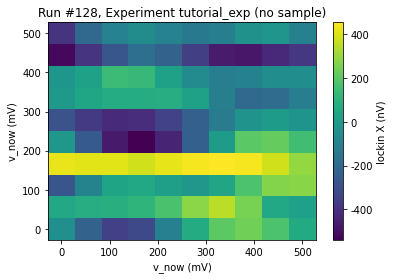

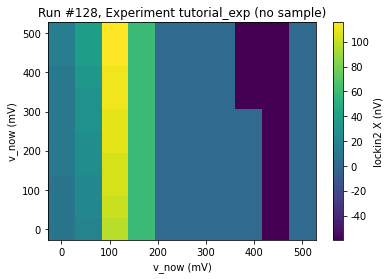

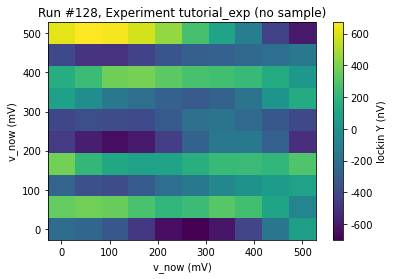

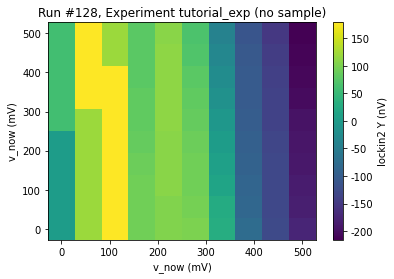

In [9]:
# ploting the data
plot_dataset(datatuple)

### Adding a non-buffered parameter to measure

In [10]:
devices_no_buffer = (a1.volt,)

In [11]:
datatuple = do2d_multi(param_slow = slow.v_now,
           start_slow = 0,
           stop_slow = 0.5,
           num_points_slow = 10,
           delay_slow = 0.05,
           param_fast = fast.v_now,
           start_fast = 0,
           stop_fast = 0.5,
           num_points_fast = 10, 
           delay_fast = 0.07,
           lockins = lockins,
           devices_no_buffer = devices_no_buffer, 
           channels = 1,
           threading=[True,False,False,True],
           attempts_to_get=50,
           delay_fast_increase=0.00
              )

  0%|          | 0/10 [00:00<?, ?it/s]

Starting experimental run with id: 129. 
Starting experimental run with id: 130. 



Fast parameter: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Slow parameter: 100%|██████████| 10/10 [00:53<00:00,  5.31s/it]


([<AxesSubplot:title={'center':'Run #129, Experiment tutorial_exp (no sample)'}, xlabel='v_now (mV)', ylabel='v_now (mV)'>,
  <AxesSubplot:title={'center':'Run #129, Experiment tutorial_exp (no sample)'}, xlabel='v_now (mV)', ylabel='v_now (mV)'>],
  <matplotlib.colorbar.Colorbar at 0x2006539f6a0>])

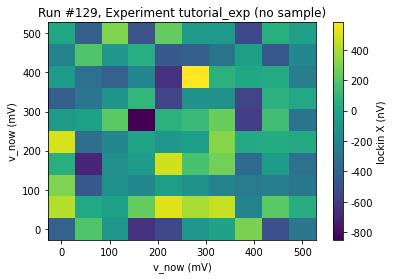

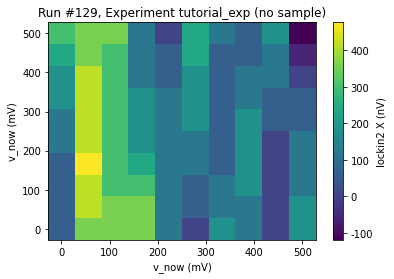

In [12]:
plot_dataset(datatuple[0])

([<AxesSubplot:title={'center':'Run #130, Experiment tutorial_exp (no sample)'}, xlabel='v_now (mV)', ylabel='v_now (mV)'>],
 [<matplotlib.colorbar.Colorbar at 0x2006643b310>])

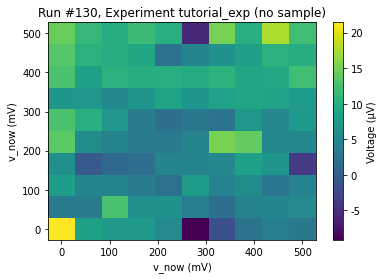

In [13]:
plot_dataset(datatuple[1])

A file 'do2dmulti.log' is generated with timing information